In [1]:
import h5py
import psana
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import  rotate
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit,minimize
import multiprocessing
import os
from functools import partial
import time
import sys
import argparse
from datetime import datetime
import tempfile
import XSpect.XSpect_Analysis
import XSpect.XSpect_Controller
import XSpect.XSpect_Visualization


<font size=5>XES Analysis and Visualization Test<br>WITH ROTATION</font>

In [2]:
xes_experiment = XSpect.XSpect_Analysis.spectroscopy_experiment(hutch='xcs',experiment_id='xcsp23820',lcls_run=21)
xes=XSpect.XSpect_Controller.XESBatchAnalysisRotation()
xes.end_index=-1
#8000#2000#only import the first 5000 shots
xes.mintime=-2
xes.maxtime=10
xes.numpoints=240
xes.adu_cutoff=[30,9909]#3.0
xes.angle=1.3
xes.pixels_to_patch=[225,350,351,352,353,354,355,356,436,437]
xes.key_epix=['epix_1/ROI_0_area']
xes.set_key_aliases(keys=['tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_1/ROI_0_area'], names=['time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix'])
xes.rois=[[0,-1]]#[[22,30]]
#xes.add_filter('xray','ipm4',1.0E3)
#xes.add_filter('simultaneous','ipm4',1.0E3)
#xes.add_filter('simultaneous','time_tool_ampl',0.15)
xes.run_parser(['211-224'])


In [3]:
start=time.time()
#xes.primary_analysis_parallel_loop(16,xes_experiment)
xes.primary_analysis_parallel_range(16,xes_experiment,increment=2000)
end=time.time()

Processing: 100%|██████████| 254/254 [08:59<00:00,  2.12s/Shot_Batch]


In [ ]:
print(end-start)
#563 seconds for 5000 increment.
#557 for 10000 increment.
#about 90 seconds per 10K shots per core
#74shots per second when ran on 2000 shots.b
#18 shots per second when ran on 10000 shots.
#489 seconds for all shots with a 2000 increment.
#71 shots per second for 8000 in 2000 increment 2 cores. After purging memory.
#447 seconds with crappy purge
#498 seconds with 16 cores. Something is bogus.

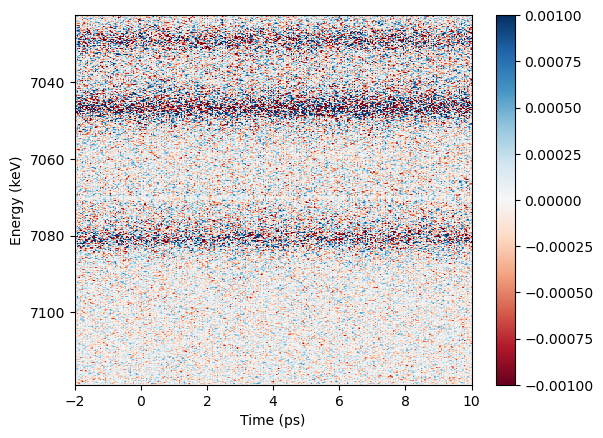

In [8]:
np.shape(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1)
v=XSpect.XSpect_Visualization.XESVisualization()
v.combine_spectra(xes_analysis=xes,xes_key='epix_xray_not_laser_time_binned_ROI_1',xes_laser_key='epix_simultaneous_laser_time_binned_ROI_1')
v.vmin=-0.001
v.vmax=0.001

v.plot_2d_difference_spectrum(xes)

np.save('xray_norm.np',xes.summed_laser_on_normalized)
np.save('laser_norm.np',xes.summed_laser_off_normalized)

In [7]:
import pickle 

file_pi = open('test.obj', 'wb') 
pickle.dump(xes, file_pi)

In [9]:
xes.analyzed_runs[1].status

['New analysis of run 211 located in: /sdf/data/lcls/ds/xcs/xcsp23820/hdf5/smalldata/xcsp23820_Run0211.h5',
 'Obtained shot properties',
 'HDF5 import of keys completed. Time: 0.19 seconds',
 'HDF5 import of keys completed kept as hdf5 dataset. Time: 0.14 seconds',
 'Key: epix has been adu filtered by thresholds: 30.000000,9909.000000',
 'Detector epix pixel 225 patched. Old value.',
 'Detector epix pixel 350 patched. Old value.',
 'Detector epix pixel 351 patched. Old value.',
 'Detector epix pixel 352 patched. Old value.',
 'Detector epix pixel 353 patched. Old value.',
 'Detector epix pixel 354 patched. Old value.',
 'Detector epix pixel 355 patched. Old value.',
 'Detector epix pixel 356 patched. Old value.',
 'Detector epix pixel 436 patched. Old value.',
 'Detector epix pixel 437 patched. Old value.',
 'Shots combined for detector epix on filters: simultaneous and laser into epix_simultaneous_laser',
 'Shots (282) separated for detector epix on filters: xray and laser into epix_x

In [8]:
xes.analyzed_runs[0].encoder

array([2.32654916, 2.31667564, 2.30653526, ..., 6.69625066, 6.68624371,
       6.67637019])

In [9]:
np.shape(xes.analyzed_runs[1].epix_simultaneous_laser_time_binned_ROI_1)

(241, 702)

In [8]:
np.max(xes.analyzed_runs[1].timing_bin_indices)

228

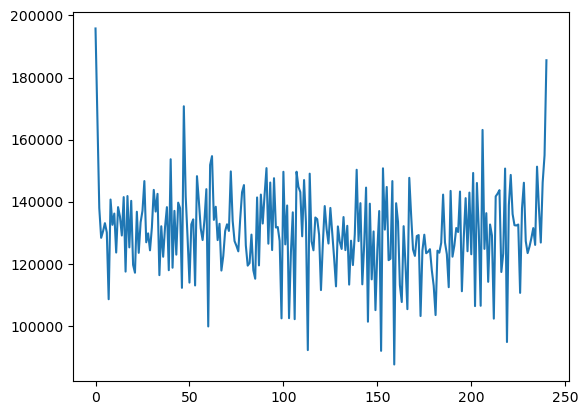

In [20]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:],axis=1))

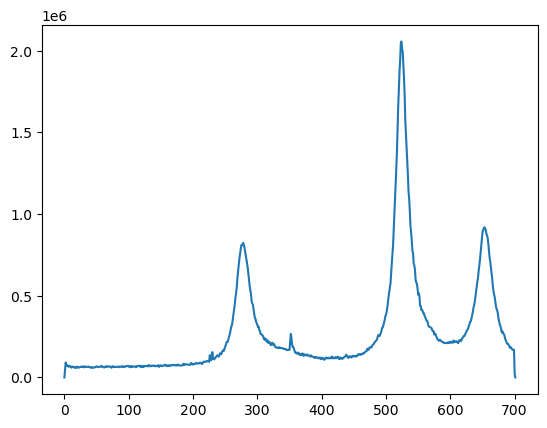

In [21]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1[:],axis=0))
#plt.plot(np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:]*6,axis=0))
#plt.axvline(350)
#plt.axvline(356)
#plt.xlim(340,360)

In [9]:
import h5py
fs=h5py.File(r'/sdf/data/lcls/ds/xcs/xcsp23820/hdf5/smalldata/xcsp23820_Run0247.h5')

In [10]:
import numpy as np
epix=np.array(fs['epix_1/ROI_0_area'])[:2000]
epix=epix*(epix>30.0)
epix=epix*(epix<999.0)
epix=np.nansum(epix,axis=0)
#epix=rotate(epix,1.3)

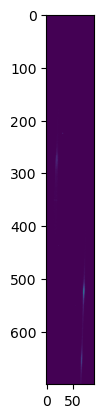

In [11]:
import matplotlib.pyplot as plt
plt.imshow(epix,vmin=0,vmax=100000)

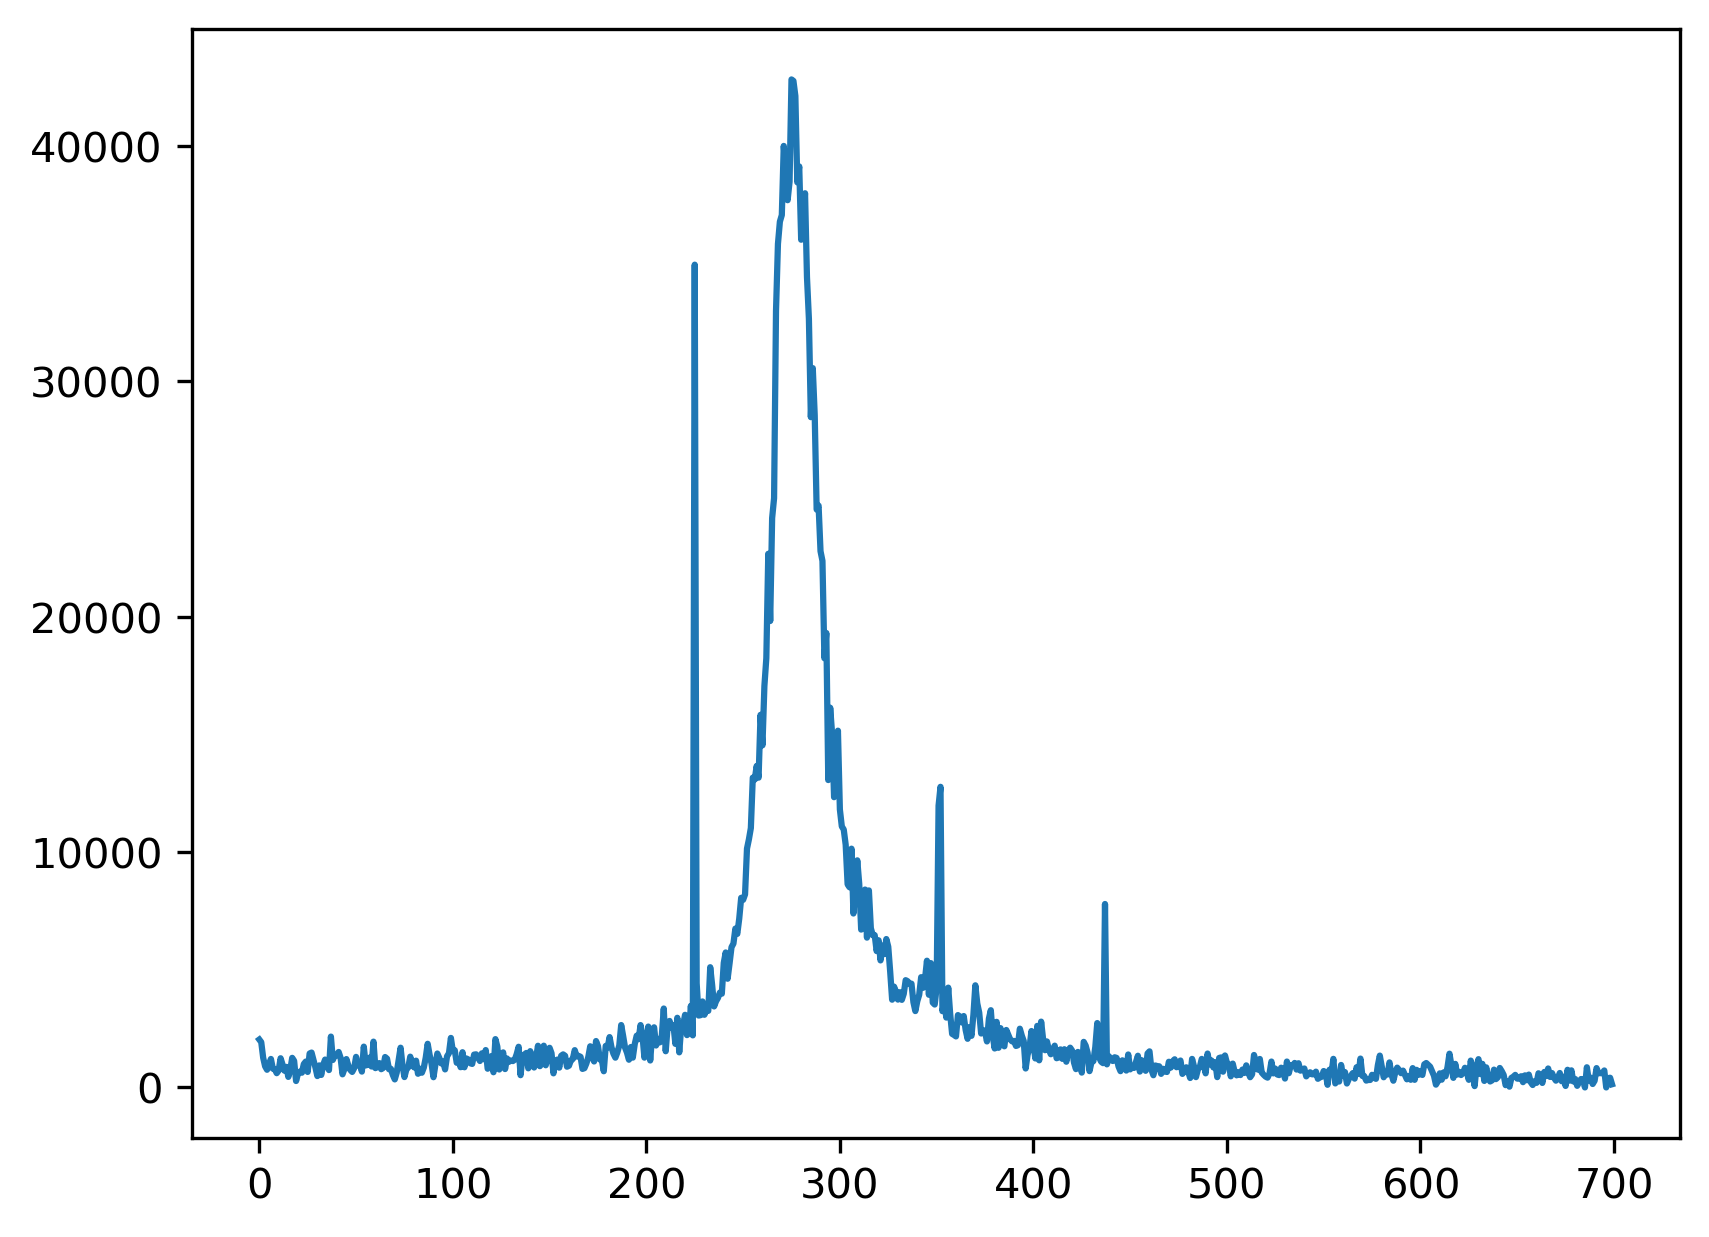

In [12]:
plt.figure(dpi=300)
plt.plot(np.nansum(epix[:,18:35],axis=1))
#plt.plot(np.nansum(epix[:,22:30],axis=1))
#plt.xlim([434,440])

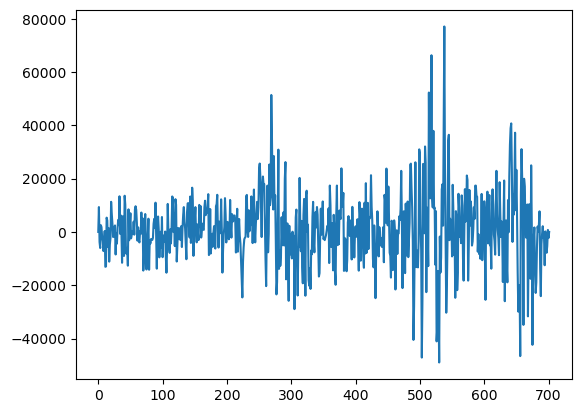

In [13]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1[:],axis=0)-np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:]*6,axis=0))


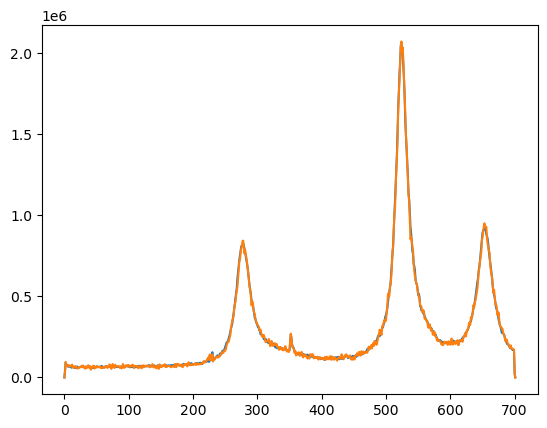

In [14]:
plt.plot(np.sum(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1[:],axis=0))
plt.plot(np.sum(xes.analyzed_runs[0].epix_xray_not_laser_time_binned_ROI_1[:]*6,axis=0))

In [15]:
np.shape(xes.analyzed_runs[0].epix_xray_not_laser)

(5087, 702, 106)

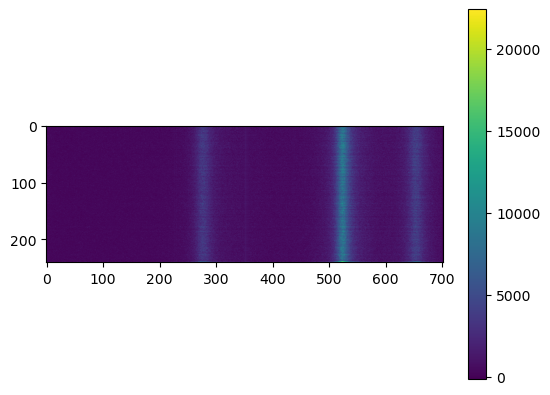

In [16]:
plt.imshow(xes.analyzed_runs[0].epix_simultaneous_laser_time_binned_ROI_1)
plt.colorbar()

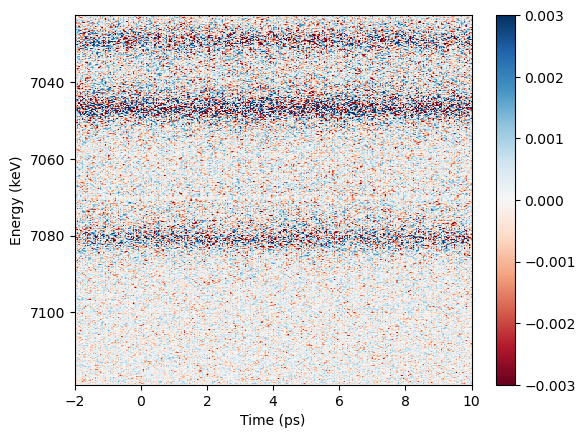

In [24]:
import sys

In [28]:
sys.getsizeof(v)

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.

48

In [27]:
import pickle
file_pi = open('test.obj', 'wb') 
pickle.dump(xes, file_pi)

OSError: [Errno 28] No space left on device

In [5]:
for r in xes.analyzed_runs:
    for j,k in zip(r.status_datetime,r.status):
        print(j,k)
        
    print('\n')

2024-02-05 00:09:09 New analysis of run 211 located in: /sdf/data/lcls/ds/xcs/xcsp23820/hdf5/smalldata/xcsp23820_Run0211.h5
2024-02-05 00:09:09 Obtained shot properties
2024-02-05 00:09:09 HDF5 import of keys completed. Time: 0.32 seconds
2024-02-05 00:09:09 HDF5 import of keys completed kept as hdf5 dataset. Time: 0.16 seconds
2024-02-05 00:09:09 Key: epix has been adu filtered by thresholds: 30.000000,9909.000000
2024-02-05 00:09:09 Detector epix pixel 225 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 350 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 351 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 352 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 353 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 354 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 355 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 356 patched. Old value.
2024-02-05 00:09:09 Detector epix pixel 436 patched. Old value.
2024-

In [10]:
xes.analyzed_runs[3].run_number

214

In [10]:
np.save('XES_Rotation_Time_Domain.npy',xes.difference_spectrum)

In [3]:
xray=np.load('xray_norm.np.npy')
laser=np.load('laser_norm.np.npy')


In [22]:
dark=np.mean(xray,axis=0)

In [23]:
laser-dark

array([[ 0.00000000e+00,  4.85337546e-04,  1.34239260e-03, ...,
        -8.22602132e-04, -1.21954905e-04,  0.00000000e+00],
       [ 0.00000000e+00,  7.30648842e-05,  1.32801771e-03, ...,
         3.58703082e-04,  1.86829385e-04,  0.00000000e+00],
       [ 0.00000000e+00,  2.07946807e-04,  9.57573352e-04, ...,
         6.48327927e-04, -2.23108763e-04,  0.00000000e+00],
       ...,
       [ 0.00000000e+00, -6.74701900e-04,  6.41348249e-04, ...,
        -1.93427810e-04, -2.89691821e-04,  0.00000000e+00],
       [ 0.00000000e+00, -3.08278979e-04, -8.51544438e-04, ...,
        -3.76332078e-04, -2.50356779e-04,  0.00000000e+00],
       [ 0.00000000e+00, -5.06277056e-04, -9.11676571e-04, ...,
         5.23256462e-04,  8.22747242e-04,  0.00000000e+00]])

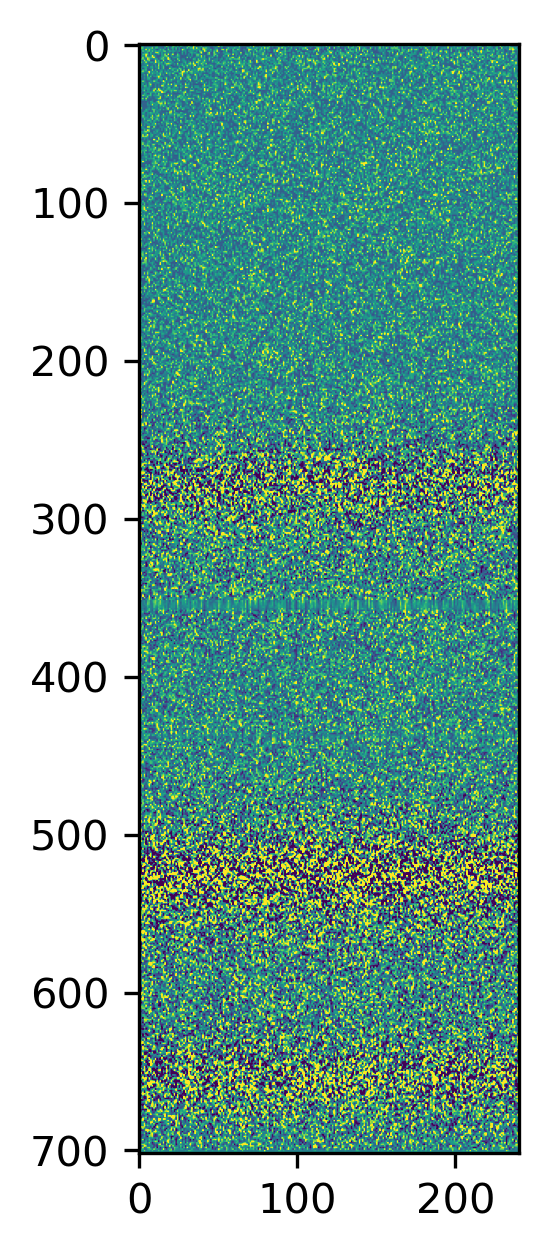

In [28]:
plt.figure(dpi=300)
plt.imshow(np.transpose(laser-dark),vmin=-0.002,vmax=0.002)


In [29]:
laser=np.load(r'./39077099/laser_norm.np.npy')
xray=np.load(r'./39077099/xray_norm.np.npy')
plt.figure(dpi=300)
plt.imshow((xray-laser).T,vmax=0.0003,vmin=-0.0003,cmap='RdBu')

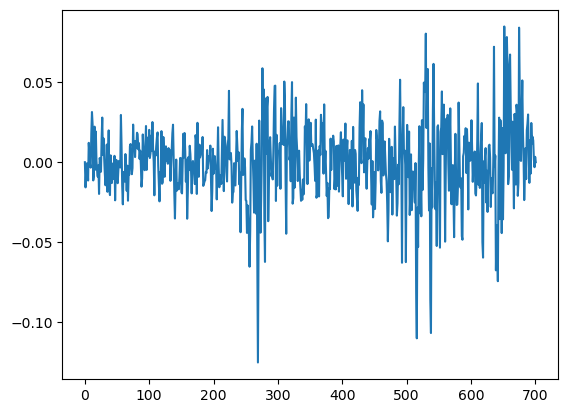

In [30]:
plt.plot(light-dark)